In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium
import numpy as np
import matplotlib.pyplot as plt

##### Make a request to the website

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
res.status_code

200

##### 200 indicates success . Now extract the content from the result

In [3]:
src = res.content

###### Use beautiful soup to extract useful content from the code

In [4]:
soup = BeautifulSoup(src,"html.parser")

In [5]:
postal = []
borough = []
neighbor = []
table = soup.findAll('table', attrs={'class':'wikitable sortable'})

###### extracting the  < tr > tags from the table

In [6]:
table_rows = table[0].find_all('tr')
table_rows = table_rows[1:]

###### Extract < td > tag from each row and place it in it's respective group

In [7]:
for a in table_rows:
    td = a.find_all('td')
    postal.append(td[0].text[:-1])
    borough.append(td[1].text[:-1])
    neighbor.append(td[2].text[:-1])

###### Create a data frame

In [8]:
df = pd.DataFrame({'PostalCode':postal,'Boroughs':borough,'Neighbourhood':neighbor})

In [9]:
df.head()

,PostalCode,Boroughs,Neighbourhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


###### Remove rows where Boroughs = ' Not assigned'

In [10]:
df = df.loc[df["Boroughs"]!='Not assigned']
df

,PostalCode,Boroughs,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
...,...,...,...
160,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,Business reply mail Processing Centre
169,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


###### Checing for rows with the same postal code

In [11]:
pcode = df["PostalCode"].unique()
len(pcode)

103

In [12]:
# from the above we can see 103 unique vales of postal code for 103 rows , so every row has a unique postal code

In [13]:
df.loc[df["Neighbourhood"] == 'Not assigned']

,PostalCode,Boroughs,Neighbourhood


In [14]:
print("Number of rows is",df.shape[0])

Number of rows is 103


In [15]:
pc = pd.read_csv("postal_code.csv")
pc.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
latitude = []
longitude = []
for i in range(df.shape[0]):
    p = df.iloc[i,0]
    latitude.append(pc.loc[pc["Postal Code"] == p,"Latitude"].values[0])
    longitude.append(pc.loc[pc["Postal Code"] == p,"Longitude"].values[0])

In [17]:
df["Latitude"] = latitude
df["Longitude"] = longitude

In [18]:
df.head(10)

,PostalCode,Boroughs,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
5,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
8,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
9,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
11,M3B,North York,Don Mills,43.745906,-79.352188
12,M4B,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937
13,M5B,Downtown Toronto,Garden District / Ryerson,43.657162,-79.378937


###### Generate a map of Toronto

In [19]:
map = folium.Map(location=[43.7, -79.4], zoom_start=10)

In [20]:
map

###### plot the points

In [21]:
for lat, lng, borough, neighborhood in zip(df["Latitude"], df["Longitude"], df["Boroughs"], df["Neighbourhood"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

###### cluster the points

In [22]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters_array = [1,2,3,4,5,6,7,8,9,10]
inertia = []
for kclusters in kclusters_array:
    toronto_grouped_clustering = df.drop(columns = ["PostalCode","Boroughs","Neighbourhood"])
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    inertia.append(kmeans.inertia_)

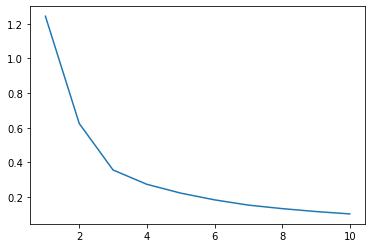

In [23]:
plt.plot(kclusters_array,inertia)

In [24]:
#using the elbow method we can see the right number of clusters are 3

In [25]:
toronto_grouped_clustering = df.drop(columns = ["PostalCode","Boroughs","Neighbourhood"])
kmeans = KMeans(n_clusters=3, random_state=0).fit(toronto_grouped_clustering)

In [26]:
# create map
map_clusters = folium.Map(location=[43.7, -79.4], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
rainbow = ["red","blue","orange"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighbourhood'], kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters